In [1]:
import datetime
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import grangercausalitytests

In [2]:
# 지표 데이터 가져오기
stock_data = pd.read_excel('../index_Infomation_v0.1.xlsx')
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3530 entries, 0 to 3529
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       3530 non-null   datetime64[ns]
 1   nasdaq_Close               3530 non-null   float64       
 2   snp500_Close               3530 non-null   float64       
 3   DJI_Close                  3530 non-null   float64       
 4   KOSPI_Close                3530 non-null   float64       
 5   samsung_PER                3530 non-null   float64       
 6   samsung_PBR                3530 non-null   float64       
 7   samsung_ROE                3530 non-null   float64       
 8   apple_PER                  3530 non-null   float64       
 9   apple_PBR                  3530 non-null   float64       
 10  gold_Close                 3530 non-null   float64       
 11  oil_Close                  3530 non-null   float64       
 12  samsun

In [3]:
compare1 = "apple"  # samsung, apple
compare2 = "Consumer price month index"
compare2data = "미국 소비자물가지수(CPI) 전월대비"

In [4]:
# 필요한 데이터만 가져오기
df = stock_data[['Date', f'{compare1}_Close', f'{compare2data}', 'dollar_to_won_Close']]
df['US_GDP_KRW'] = round(df[f'{compare2data}'] * df['dollar_to_won_Close'])
df

C:\Users\4호실-8\AppData\Local\Temp\ipykernel_12300\1357975989.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['US_GDP_KRW'] = round(df[f'{compare2data}'] * df['dollar_to_won_Close'])


,Date,apple_Close,미국 소비자물가지수(CPI) 전월대비,dollar_to_won_Close,US_GDP_KRW
0,2014-11-01,27.000000,236.151,1053.80004,248856.0
1,2014-11-02,27.000000,236.151,1053.80004,248856.0
2,2014-11-03,27.350000,236.151,1051.19995,248242.0
3,2014-11-04,27.150000,236.151,1081.59997,255421.0
4,2014-11-05,27.215000,236.151,1076.90002,254311.0
...,...,...,...,...,...
3525,2024-06-26,213.250000,314.175,1390.89001,436983.0
3526,2024-06-27,214.100006,314.175,1393.38000,437765.0
3527,2024-06-28,210.619995,314.175,1386.94995,435745.0
3528,2024-06-29,210.619995,314.175,1386.94995,435745.0


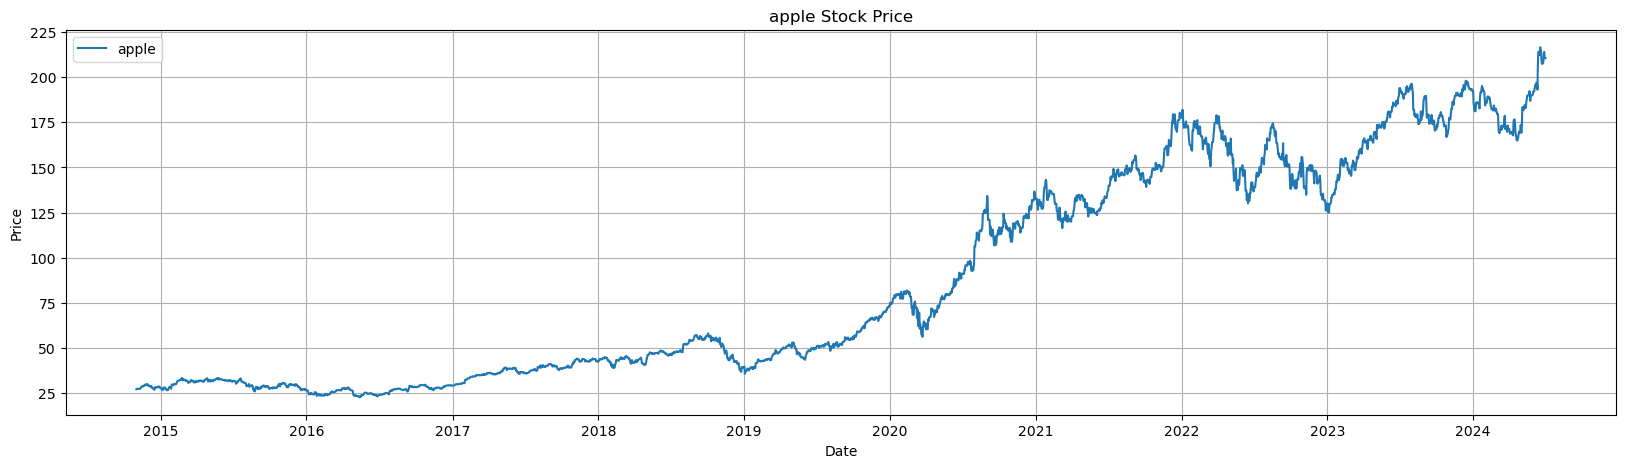

In [5]:
# 애플 주식 그래프 그리기
plt.figure(figsize=(20, 5))
plt.plot(df['Date'], df[f'{compare1}_Close'], label=f'{compare1}')

plt.title(f'{compare1} Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.show()

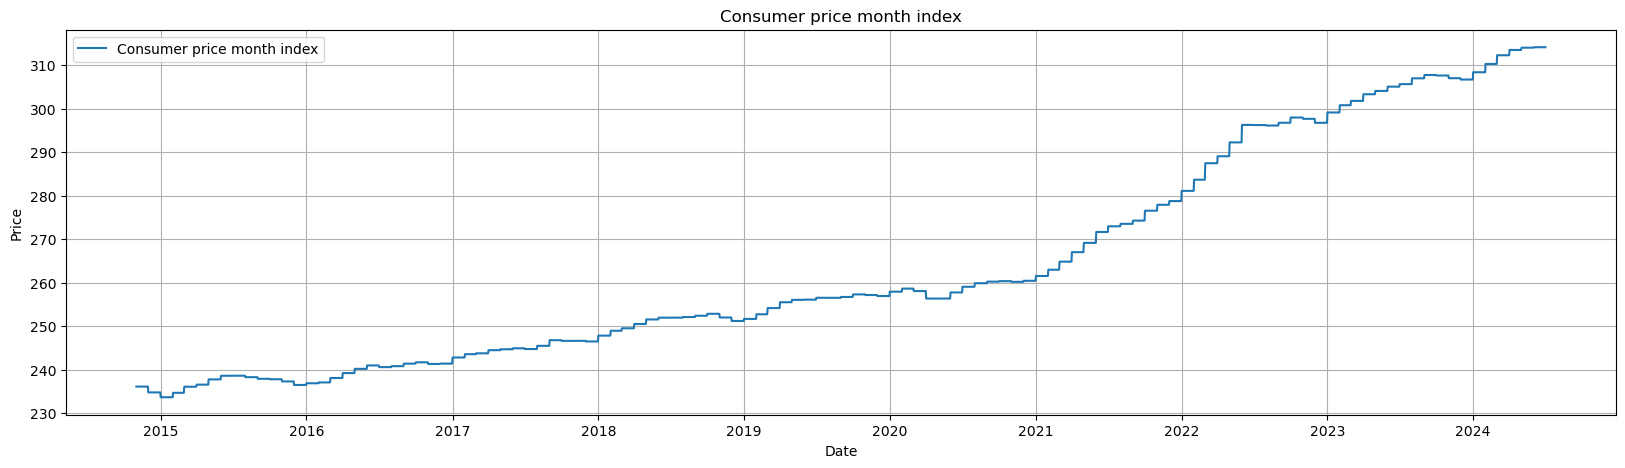

In [6]:
# CPI 전년대비
plt.figure(figsize=(20,5))
plt.plot(df['Date'], df[f'{compare2data}'], label=f'{compare2}')

plt.title(f'{compare2}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.show()

In [7]:
# 0과 1 사이의 값으로 정규화
def normalize(df, column):
    return (df[column] - df[column].min()) / (df[column].max() - df[column].min())

In [8]:
compare1_normalize = normalize(df, f'{compare1}_Close')
compare2_normalize = normalize(df, f'{compare2data}')

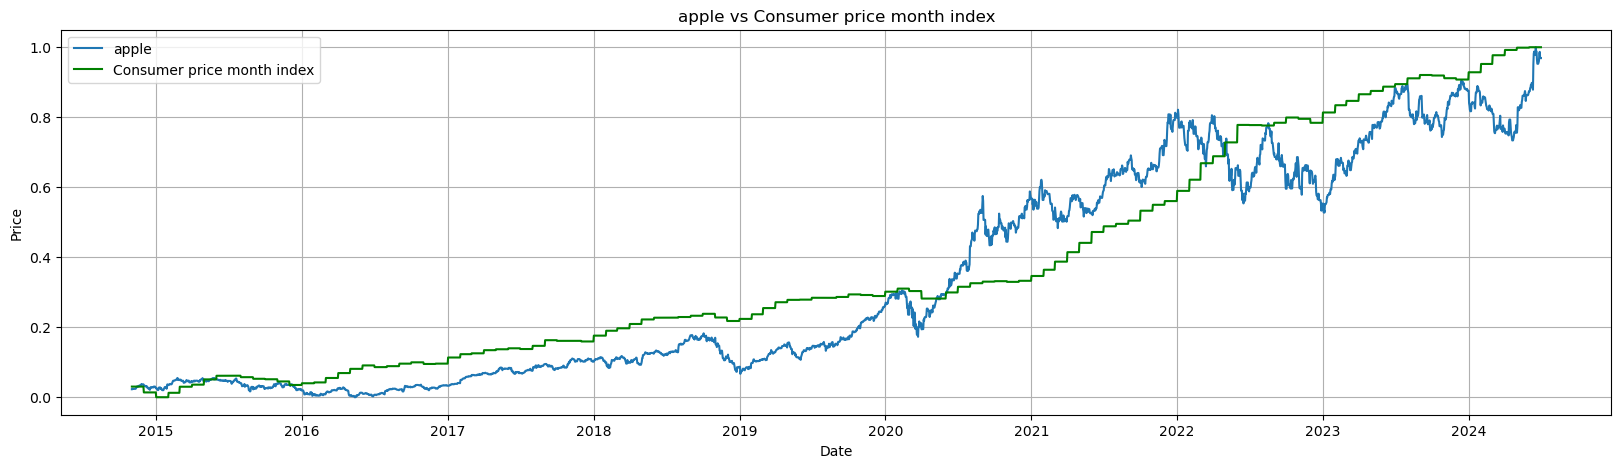

In [9]:
# 정규화 적용 애플주식과 소비자물가지수 전년대비 그래프
plt.figure(figsize=(20, 5))
plt.plot(df['Date'], compare1_normalize, label=f'{compare1}')
plt.plot(df['Date'], compare2_normalize, label=f'{compare2}', color='green')

plt.title(f'{compare1} vs {compare2}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.show()

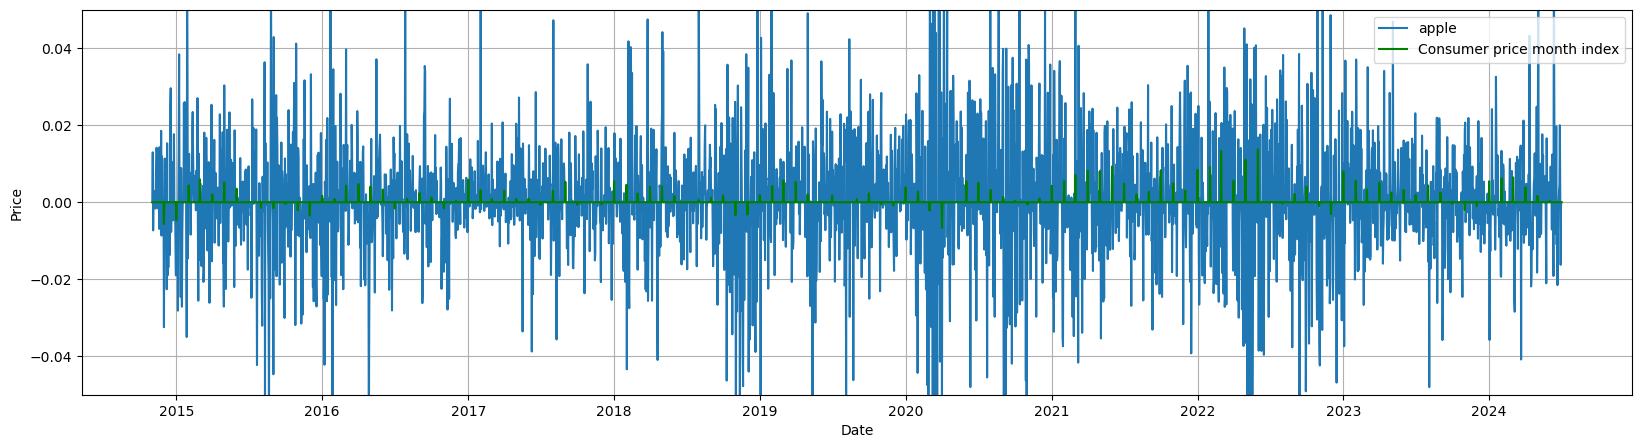

In [10]:
# 변동율 차이 비교
compare1_daily_change = df[f'{compare1}_Close'].pct_change()
compare2_daily_change = df[f'{compare2data}'].pct_change()

#그래프화
plt.figure(figsize=(20,5))
plt.plot(df['Date'], compare1_daily_change, label=f'{compare1}')
plt.plot(df['Date'], compare2_daily_change, label=f'{compare2}', color='green')
plt.ylim(-0.05, 0.05)

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


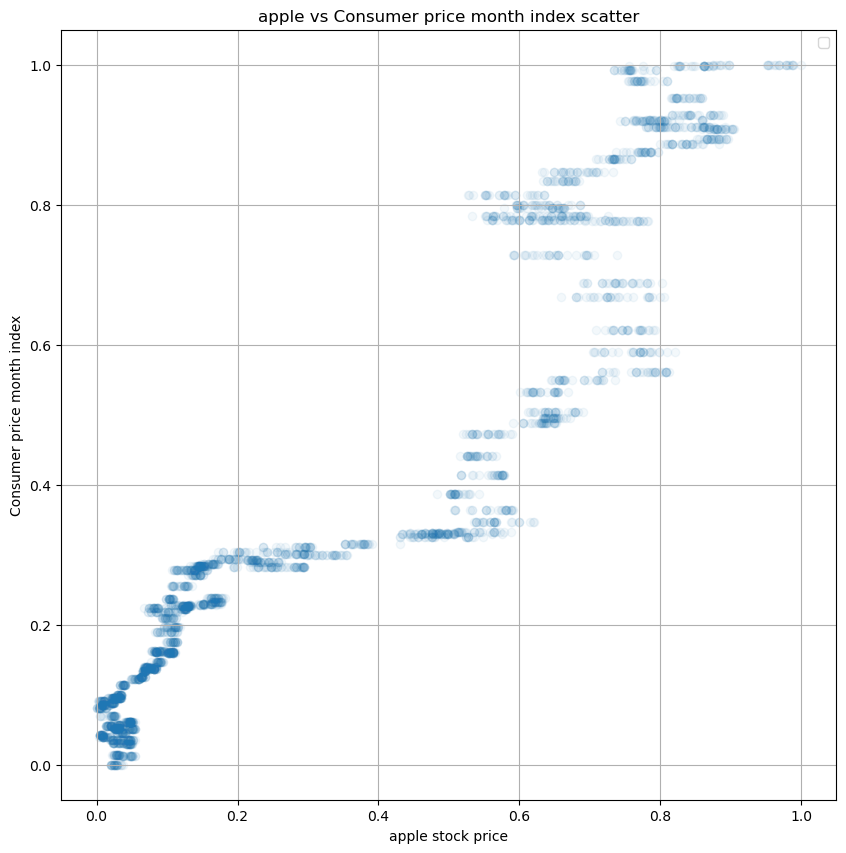

In [11]:
# 정규화 데이터로 산점도 그래프
plt.figure(figsize=(10,10))
plt.scatter(compare1_normalize, compare2_normalize, alpha=0.05)

plt.title(f'{compare1} vs {compare2} scatter')
plt.xlabel(f'{compare1} stock price')
plt.ylabel(f'{compare2}')
plt.legend()
plt.grid(True)

plt.show()

In [12]:
# Calculate the correlation
correlation = df[f'{compare2data}'].corr(df[f'{compare1}_Close'])
print(f"Correlation between {compare2} and {compare1} Stock Price: {correlation:.2f}")

Correlation between Consumer price month index and apple Stock Price: 0.94


In [13]:
# 필요한 데이터만 가져오기
df = stock_data[['Date', f'{compare1}_Close', f'{compare2data}', 'dollar_to_won_Close']]
df['US_GDP_KRW'] = round(df[f'{compare2data}'] * df['dollar_to_won_Close'])
df.head(3)

def normalize_data(series):
    # MinMaxScaler를 사용하여 데이터를 -1과 1 사이로 정규화
    scaler = MinMaxScaler(feature_range=(-1, 1))
    return scaler.fit_transform(series.values.reshape(-1, 1))

def Regression(compare1, compare2data, compare2):
    # 데이터 정규화
    stock_data[f'{compare1}_Close_Normalized'] = normalize_data(stock_data[f'{compare1}_Close'])
    stock_data[f'{compare2data}_Normalized'] = normalize_data(stock_data[f'{compare2data}'])

    # 선형 회귀 분석
    X = stock_data[f'{compare1}_Close_Normalized']
    y = stock_data[f'{compare2data}_Normalized']
    X = sm.add_constant(X)  # 상수항 추가
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)

    # 회귀 분석 결과 출력
    print(model.summary())

    # 산점도 및 회귀선 그래프
    plt.scatter(stock_data[f'{compare2data}_Normalized'], stock_data[f'{compare1}_Close_Normalized'], label='Data points')
    plt.plot(stock_data[f'{compare2data}_Normalized'], predictions, color='red', label='Regression line')
    plt.xlabel(f'{compare2} (Normalized)')
    plt.ylabel(f'{compare1} (Normalized)')
    plt.legend()
    plt.show()

C:\Users\4호실-8\AppData\Local\Temp\ipykernel_12300\1423842406.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['US_GDP_KRW'] = round(df[f'{compare2data}'] * df['dollar_to_won_Close'])


In [14]:

def rolling_correlation_and_granger_test(compare1, compare2data, compare2, window_size=30, max_lag=5, stock_data=stock_data):
    col1 = f'{compare1}_Close'
    col2 = compare2data

    # 날짜 인덱스 설정
    if not pd.api.types.is_datetime64_any_dtype(stock_data.index):
        stock_data.index = pd.to_datetime(stock_data['Date'])
        stock_data = stock_data.drop(columns=['Date'])

    # 롤링 상관관계 계산
    rolling_corr = stock_data[col1].rolling(window=window_size).corr(stock_data[col2]).dropna()

    # 무한 값과 NaN 값 제거
    rolling_corr = rolling_corr[~rolling_corr.isin([np.inf, -np.inf])].dropna()

    # 롤링 상관관계 그래프 그리기
    plt.figure(figsize=(10, 6))
    plt.plot(rolling_corr)
    plt.xlabel('Date')
    plt.ylabel('Rolling Correlation')
    plt.title(f'Dynamic Correlation between {col1} and {compare2}')
    plt.show()

    # 롤링 상관관계의 히스토그램 그리기
    plt.figure(figsize=(10, 6))
    plt.hist(rolling_corr, bins=30, edgecolor='k')
    plt.xlabel('Rolling Correlation')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Rolling Correlations between {col1} and {compare2}')
    plt.show()

    # 그랜저 인과성 테스트
    granger_test_result = grangercausalitytests(stock_data[[col1, col2]], max_lag, verbose=True)

    return rolling_corr, granger_test_result

In [15]:
def Granger(compare1, compare2data, compare2, stock_data=stock_data):
    if f'{compare1}_Close' not in stock_data.columns or compare2data not in stock_data.columns:
        raise KeyError(f"Columns {compare1}_Close and/or {compare2data} not found in the provided DataFrame")
    
    max_lag = 2
    result1 = grangercausalitytests(stock_data[[f'{compare1}_Close', compare2data]], max_lag, verbose=True)
    result2 = coint_johansen(stock_data[[f'{compare1}_Close', compare2data]], det_order=-1, k_ar_diff=1)
    
    return result1, result2.lr1, result2.cvt

c:\Anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9200  , p=0.0876  , df_denom=3526, df_num=1
ssr based chi2 test:   chi2=2.9225  , p=0.0874  , df=1
likelihood ratio test: chi2=2.9213  , p=0.0874  , df=1
parameter F test:         F=2.9200  , p=0.0876  , df_denom=3526, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8306  , p=0.1605  , df_denom=3523, df_num=2
ssr based chi2 test:   chi2=3.6664  , p=0.1599  , df=2
likelihood ratio test: chi2=3.6645  , p=0.1601  , df=2
parameter F test:         F=1.8306  , p=0.1605  , df_denom=3523, df_num=2
                                   OLS Regression Results                                  
Dep. Variable:     미국 소비자물가지수(CPI) 전월대비_Normalized   R-squared:                       0.889
Model:                                         OLS   Adj. R-squared:                  0.889
Method:                              Least Squares   F-statistic:                 2.828e+04
Date:                   

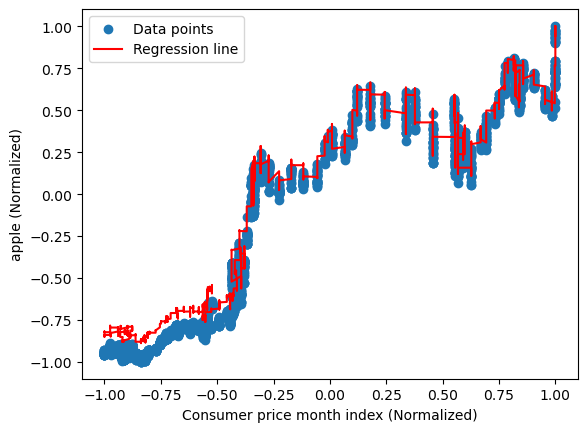

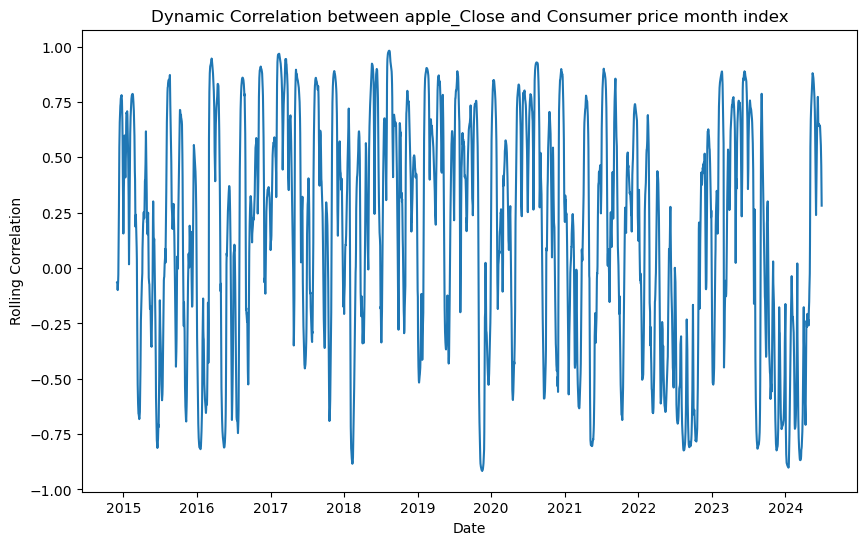

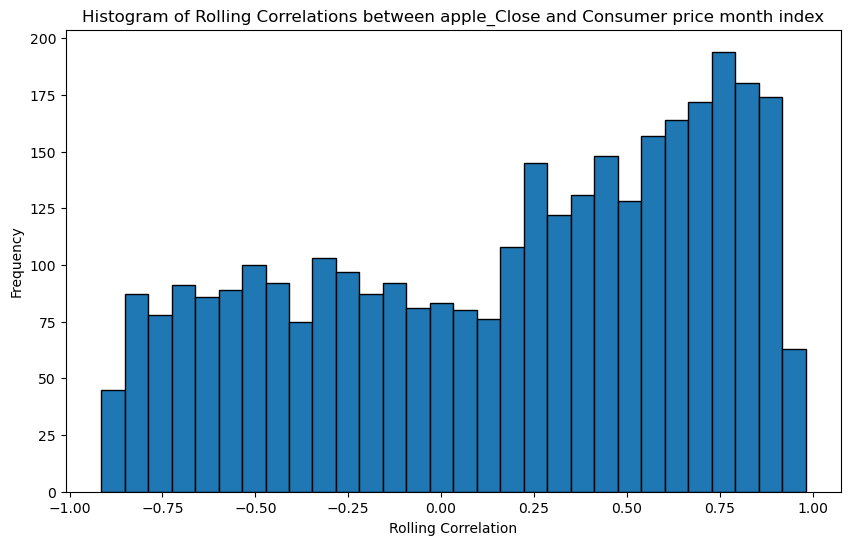


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9200  , p=0.0876  , df_denom=3526, df_num=1
ssr based chi2 test:   chi2=2.9225  , p=0.0874  , df=1
likelihood ratio test: chi2=2.9213  , p=0.0874  , df=1
parameter F test:         F=2.9200  , p=0.0876  , df_denom=3526, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8306  , p=0.1605  , df_denom=3523, df_num=2
ssr based chi2 test:   chi2=3.6664  , p=0.1599  , df=2
likelihood ratio test: chi2=3.6645  , p=0.1601  , df=2
parameter F test:         F=1.8306  , p=0.1605  , df_denom=3523, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3987  , p=0.2412  , df_denom=3520, df_num=3
ssr based chi2 test:   chi2=4.2045  , p=0.2402  , df=3
likelihood ratio test: chi2=4.2020  , p=0.2405  , df=3
parameter F test:         F=1.3987  , p=0.2412  , df_denom=3520, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4017  , p=0.

c:\Anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [16]:
def everything(compare1, compare2data, compare2):
    Granger(compare1, compare2data, compare2)
    Regression(compare1, compare2data, compare2)
    rolling_correlation_and_granger_test(compare1, compare2data, compare2)
everything(compare1, compare2data, compare2)